# CEE 598: Uncertainty Quantification
## Assignment Three
### Noah Garfinkle (garfink2@illinois edu)
### 03 March 2020

The following Jupyter notebook presents all code, results, and discussion.  The code is developed and tested using Python 3.7, with the notebook tested using Jupyter Lab.  Please let me know if you have any questions or would like any assistance running the code, or if you would prefer my work in a different format.  Please note that most calculated values are stochastic, and as such some variation will occur between runs.  After writing this report, I have cleared the kernel and rerun the notebook one last time in order to make sure all code runs linearly before submitting, and as such some of my figure values may not perfectly match example values I provide in the writeup.  However, they should be close and should further illustrate the write-up.

## Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd
import time

## Problem One

Similar to importance sampling example in lecture notes, we would lke now to calculate $\theta = P(X>2)$ where $X$ is distributed according to the standard Cauchy PDF, given by

$$
f_X(x) = \frac{1}{\pi(1+x^2)}
$$

Consider the proposal to be $q_x(x) = \frac{2}{x^2}$ defined over the domain of interest.  Write a Monte Carlo (MC) integration code, as well as importance sampling code for the estimation of $\theta$.  The input to these codes should be the size of the sample set $n$.  Let $\hat{\theta_f}$ be the result obtained from standard MC method and $\hat{\theta_g}$ be that from importance sampling.

### (a) Compare the convergence behaviors for $\hat{\theta_f}$ and $\hat{\theta_g}$.

In [2]:
def f(x):
    fx = 1 / (np.pi*(1+np.power(x,2)))
    return fx

In [3]:
def q(x):
    qx = 2 / np.power(x,2)
    return qx

Plot to compare the distributions

In [4]:
xs = np.linspace(1.9,10,200)
fs = [f(x) for x in xs]
qs = [q(x) for x in xs]

Text(0, 0.5, '$P(X==x)$')

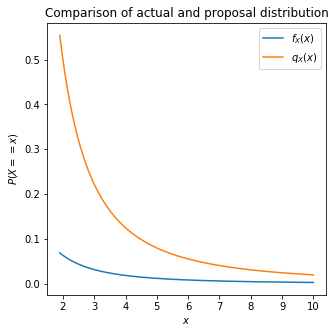

In [5]:
fig,ax = plt.subplots(figsize=(5,5))
sns.lineplot(xs,fs,label="$f_X(x)$",ax=ax)
sns.lineplot(xs,qs,label="$q_X(x)$",ax=ax)
ax.set_title("Comparison of actual and proposal distribution")
ax.set_xlabel("$x$")
ax.set_ylabel("$P(X==x)$")

For reference, estimate what the actual area should be by using the Scipy built-in Cauchy distribution

In [6]:
stats.cauchy.cdf(100000)-stats.cauchy.cdf(2)

0.14758043455157155

#### Monte Carlo Integration

Approach:

Let us assume that the maximum value of the distirbution, per the figure above, is 0.1.  Therefore, we will randomly select values on the x axis between 2 and a large number (a number with a very small probability along the tail), and between 0 and 0.1.  We will check whether they fall under the curve.

In [7]:
%%time
n = 100000
min_x = 2.0
max_x = 100
min_y = 0.0
max_y = 0.1
sample_xs = []
sample_ys = []
p_xs = []
sample_hits = []
for i in range(0,n):
    sample_x = np.random.random() * max_x
    sample_y = np.random.random() * max_y
    p_x = f(sample_x)
    if sample_y < p_x:
        sample_hits.append(True)
    else:
        sample_hits.append(False)
    sample_xs.append(sample_x)
    sample_ys.append(sample_y)
    p_xs.append(p_x)
df_mc = pd.DataFrame({"x":sample_xs,"y":sample_ys,"f(x)":p_xs,"hit":sample_hits})

Wall time: 518 ms


In [8]:
area_rectangle = (max_x-min_x) * (max_y-min_y)
nHits = len(df_mc[(df_mc["hit"]==True) & (df_mc["x"]>min_x)])
fractionHits = nHits / n
fractionArea = fractionHits * area_rectangle

In [9]:
fractionArea

0.13739600000000002

Text(0.5, 1.0, 'Monte Carlo approach to area estimation with 100000 samples\n$P(x>2)=0.14$')

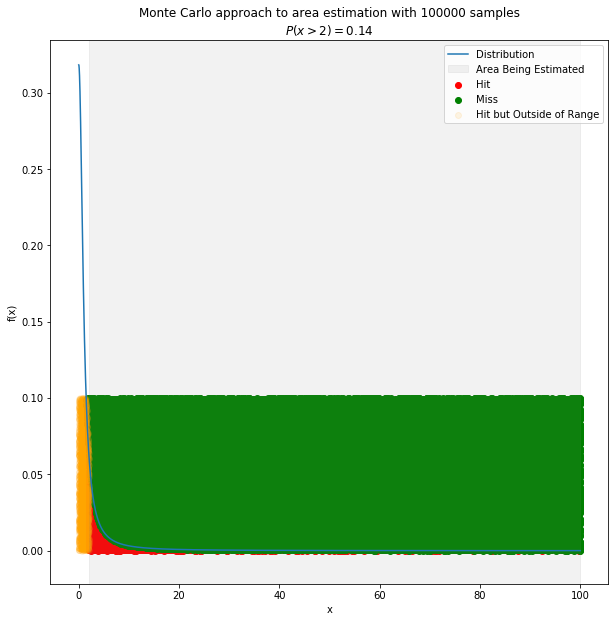

In [10]:
fig,ax = plt.subplots(figsize=(10,10))
df_Miss = df_mc[df_mc["hit"]==False]
df_hitAbove2 = df_mc[(df_mc["hit"]==True) & (df_mc["x"]>min_x)]
df_hitBelow2 = df_mc[(df_mc["hit"]==True) & (df_mc["x"]<=min_x)]
ax.scatter(x=df_hitAbove2["x"],y=df_hitAbove2["y"],color="red",label="Hit")
ax.scatter(x=df_Miss["x"],y=df_Miss["y"],color="green",label="Miss")
ax.scatter(x=df_hitBelow2["x"],y=df_hitBelow2["y"],color="orange",label="Hit but Outside of Range",alpha=0.1)
ax.axvspan(min_x,max_x,alpha=0.1,color="grey",label="Area Being Estimated")
sns.lineplot(x="x",y="f(x)",data=df_mc,ax=ax,label="Distribution")
ax.set_title(f"Monte Carlo approach to area estimation with {n} samples\n$P(x>2)={fractionArea:,.2f}$")

#### Importance Sampling

Approach
- I will begin by creating a random number generator out of our proposal distribution.  Because the PDF, $q_X(x)=\frac{2}{x^2}$,
- The CDF, $Q_X(x)=\int{\frac{2}{x^2}} = \frac{-2}{x}$
- $\therefore$ the inverse CDF is $\frac{-2}{y}$
- We can use this to construct a random number generator for our importance sampling measure.

References

- https://astrostatistics.psu.edu/su14/lectures/cisewski_is.pdf
- https://people.duke.edu/~ccc14/sta-663/MonteCarlo.html

In [11]:
def inversecdf(y):
    x = 2.0 / y
    return x

In [12]:
%%time
sample_xs = []
Pzs = []
Pzs_scaled = []

n = 100000
Pz = 0.0
for i in range(0,n):
    # pick a random x
    rand = np.random.random()
    x = inversecdf(rand)
    sample_xs.append(x)
    if x > min_x:
        Pz += f(x) / q(x)
        Pzs.append(Pz) 
        if i > 0:
            Pzs_scaled.append(Pz/i)
        else:
            Pzs_scaled.append(0.0)
Pz /= n

df_is = pd.DataFrame({"x":sample_xs,"Pz":Pzs,"Pz Scaled":Pzs_scaled})

Wall time: 646 ms


In [13]:
Pz

0.14764590872681183

#### Discussion

As expected, importance sampling provides a much better estimate of the tail probability, while as expected the Monte Carlo method is slightly faster for the same number of samples $n=100,000$.  Running on a Windows 10 PC with a 3.5 GHz quad-core processor and 32 gigabytes of ram, both approaches take approximatley 1/2 second.  The core difference, however, is the performance of the estimator.  For 100,000 samples, the Monte Carlo approach estimates 0.143, versus an estimated more-accurate value calculated above of 0.148.  The importance sampling estimates bound 0.148 using even 100 samples, at a runtime too small for my code profiler to track, demosntrating substantial performance benefits.

### (b) At each sample number, use the previous samples to calculate the sample variance for the $\theta$ estimates, i.e. $Var(\hat{\theta_f})$ and $Var(\hat{\theta_g})$.  Compare these two measures and their convergences.

Appraoch

- There are a number of ways to approach variance, considering that I have an estimate of the true sample expectation (option 1).  For option 2, I could have utilized the expectation for each subset of samples.  I opted for option 3, in which I compared each distribution to its end estimate of $\theta$.  Changing this would be as simple as swapping values (options 1 and 3) or a little bit of additional code (option 2).
- I felt this approach was most instructive, as the true expectation would likely not be known in a more complex case, and overall convergence behavior is what I was interested in studying.

References

- https://people.duke.edu/~ccc14/sta-663/MonteCarlo.html

In [14]:
# For sake of comparison, take the actual value to be
θ_actual = stats.cauchy.cdf(100000)-stats.cauchy.cdf(2)

Variance analysis for the Monte Carlo algorithm

In [18]:
θ_fs = []
var_θ_fs = []
for i in range(1,n):
    df_mc_subset = df_mc[0:i]
    # estimate theta and theata variance
    hitDF = df_mc_subset[(df_mc_subset["hit"]==True) & (df_mc_subset["x"]>min_x)]
    nHits = len(hitDF)
    fractionHits = nHits / n
    θ_f = fractionHits * area_rectangle
    θ_fs.append(θ_f)
    var_θ_f = np.power(θ_f-fractionArea,2)
    var_θ_fs.append(var_θ_f)

Variance analysis for the Improtance Sampling algorithm

In [19]:
df_is["Var"] = np.power(df_is["Pz Scaled"]-Pz,2)

Compare the behavior of both algorithms

Text(0.5, 0, 'Iteration')

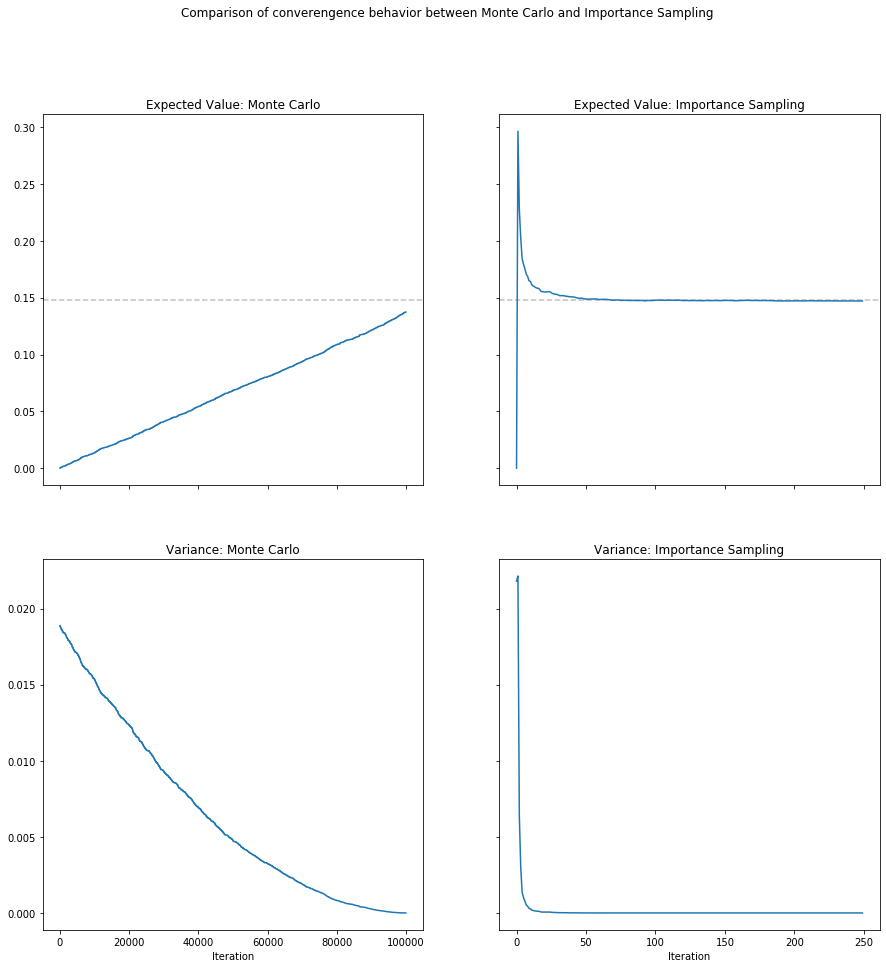

In [20]:
fig,ax = plt.subplots(2,2,figsize=(15,15),sharey="row",sharex="col")
fig.suptitle("Comparison of converengence behavior between Monte Carlo and Importance Sampling")

ax[0,0].plot(θ_fs)
ax[0,0].set_title("Expected Value: Monte Carlo")
ax[1,0].plot(var_θ_fs)
ax[1,0].set_title("Variance: Monte Carlo")
ax[1,0].set_xlabel("Iteration")

ax[0,0].axhline(θ_actual,ls="--",color="grey",alpha=0.5)
ax[0,1].axhline(θ_actual,ls="--",color="grey",alpha=0.5)

ax[0,1].plot(df_is["Pz Scaled"][0:250])
ax[0,1].set_title("Expected Value: Importance Sampling")
ax[1,1].plot(df_is["Var"][0:250])
ax[1,1].set_title("Variance: Importance Sampling")
ax[1,1].set_xlabel("Iteration")

### (c) Discuss your observations

While both approaches start at relatively similar values of variance, the decay of variance for importance sampling is very impressive, with convergence appearing to arise in fewer than 150 iterations.  For the Monte Carlo approach, 100,000 samples appear to lead the algorithm towards asymptotically approaching convergence, however even here convergence may not yet have been reached.  As such, importance sampling is highly superior in this application, achieving a better approximation of the integral in substantially less time.

## Problem Two

Write a Metropolis-Hastings code that can be used to draw samples from the Rayleigh PDF given by

$$
f(x;\sigma)=\frac{x}{\sigma^2}e^{\frac{-x^2}{2\sigma^2}}, x\geq0
$$

Choose the proposal to be $q(y|x)=N(x,\sigma_q^2)$

In [21]:
def f_rayleigh(x,σ):
    p = x / np.power(σ,2)*np.exp(-np.power(x,2)/(2*np.power(σ,2)))
    return p

In [22]:
# I think what actually needs to happen here with my proposal is a normal distribution centered on x and with σ
def q_x(x,σ):
    normalDist = stats.norm(loc=x,scale=σ)
    proposedValue = normalDist.rvs()
    return proposedValue

First, we begin by ensuring that our impelmented distribution matches an accepted distribution.

In [23]:
xs = np.linspace(0,10,100)
fs_rayleigh = [f_rayleigh(x,1) for x in xs]
pdf_rayleigh = [stats.rayleigh.pdf(x,scale=1) for x in xs]

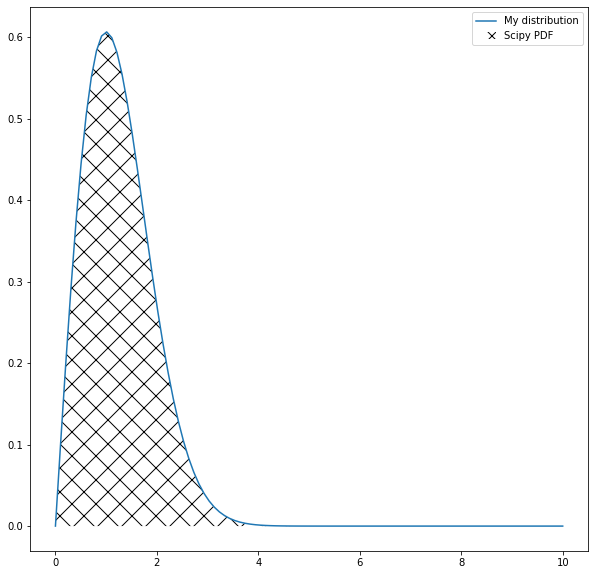

In [24]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(xs,fs_rayleigh,label="My distribution",ax=ax)
# sns.lineplot(xs,pdf_rayleigh,label="Scipy",ax=ax)
ax.fill_between(xs,pdf_rayleigh,hatch='x',facecolor="white",label="Scipy PDF")
ax.legend()

As such, my distribution as implemented appears to be a good fit.

### (a) Assume $\sigma = \sigma_q = 1$.  We have two ways to implement the algorithm now that the supports of $f$ and $q$ are different:

_Option a.1_: We draw samples from the proposal distribution, and only if they fall inside the domain interest, we consider them a candidate, based on which we evaluate the rejection probability and move to the acceptance/rejection step.  That is, if they don't fall inside the support of $f$ we don't make a self-transition, and just free the step timer, until a proposal falls inside the support.

_Option a.2_: We draw samples from the proposal distribution, and no matter where they fall (inside or outside the domain of interest), we treat them as a candidate, based on which we evaluate the rejection probability and move to the acceptance/rejection step.  That is, no matter where the proposal draw is, we will not freeze the time stepper.

Compare the two sample populations generated using these two codes with the target distribution and commennt on the options you would pick.

General Approach:

1. Set an initial value of x
2. For t = 1,2,...

    a. Obtain a proposed value from q
    
    b. Calculate the acceptance probability
    
    c. Based on the acceptance probability ,either set the next value as the proposed value or stay in place

References:
- https://stephens999.github.io/fiveMinuteStats/MH_intro.html
- https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a

#### Option a.1

For Option a.1, I have decided to consider a proposal $x$ as falling outside of the support for $f_X(x)$ if $f_X(x)<0.0$

In [25]:
iterations = []
xs = []
proposedXs = []
arr_Accepted = []

x = 1.0
σ = 1
σ_q = 1
for t in range(0,100000):
    check = -1
    while check < 0:
        # obtain a proposed value from q
        proposedValue = q_x(x,σ_q)
        # calculate the acceptance probability
        acceptanceRatio = min(1,f_rayleigh(proposedValue,1) / f_rayleigh(x,1) * stats.norm.pdf(x,scale=σ_q,loc=proposedValue) / stats.norm.pdf(proposedValue,scale=σ_q,loc=x))
        check = f_rayleigh(proposedValue,σ)
        accepted = False
        # check if it falls within the support for fx (positive probability)
        if acceptanceRatio == 1: #accept
            x = proposedValue
            accepted = True
        else: # draw a random number and take the probability from acceptanceRatio
            rand = np.random.random()
            if rand < acceptanceRatio:
                x = proposedValue
                accepted = True
            else:
                pass
    iterations.append(t)
    xs.append(x)
    proposedXs.append(proposedValue)
    arr_Accepted.append(accepted)
df = pd.DataFrame({"t":iterations,"x":xs,"proposals":proposedXs,"accepted":arr_Accepted})

Text(0, 0.5, '$x$')

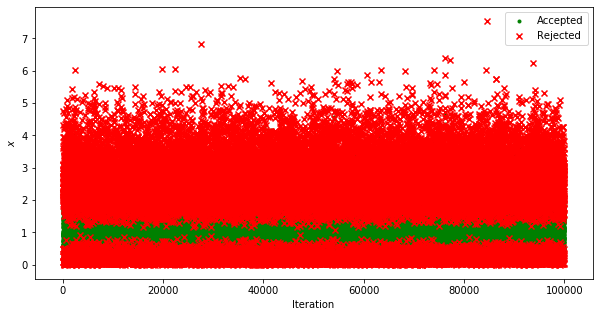

In [26]:
df_Accepted = df[df["accepted"]==True]
df_Rejected = df[df["accepted"]==False]

fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(df_Accepted["t"],df_Accepted["x"],label="Accepted",marker=".",color="green")
ax.scatter(df_Rejected["t"],df_Rejected["proposals"],label="Rejected",marker="x",color="red")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("$x$")

We can compare the expected value of our generated distribution with the expected value for a Raylleigh distribution

In [27]:
df["x"].mean()

1.3327646482568944

In [28]:
σ*np.power(np.pi/2,.5) # the true expected value of a Rayleigh distribution per https://www.statisticshowto.datasciencecentral.com/rayleigh-distribution/

1.2533141373155001

Text(0.5, 1.0, 'Metropolis-Hastings Algorithm Implementation a.1\nNote: No negative numbers are actually observed, the tail reflects the plotting library KDE')

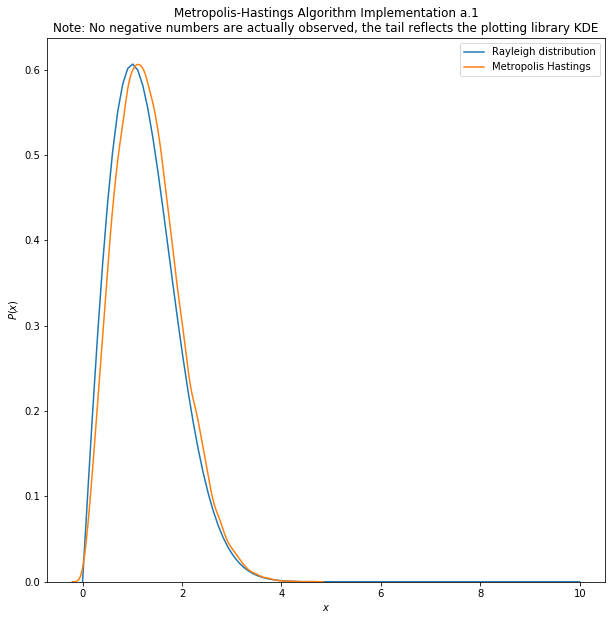

In [29]:
xs = np.linspace(0,10,100)
fs_rayleigh = [f_rayleigh(x,1) for x in xs]
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(xs,fs_rayleigh,label="Rayleigh distribution",ax=ax)
sns.kdeplot(df["x"],ax=ax,label="Metropolis Hastings")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$P(x)$")
ax.set_title("Metropolis-Hastings Algorithm Implementation a.1\nNote: No negative numbers are actually observed, the tail reflects the plotting library KDE")

#### Option a.2

In [ ]:
iterations = []
xs = []
proposedXs = []
arr_Accepted = []

x = 1.0
σ = 1
σ_q = 1
for t in range(0,100000):
    # obtain a proposed value from q
    proposedValue = q_x(x,σ_q)
    # calculate the acceptance probability
    acceptanceRatio = min(1,f_rayleigh(proposedValue,1) / f_rayleigh(x,1) * stats.norm.pdf(x,scale=σ_q,loc=proposedValue) / stats.norm.pdf(proposedValue,scale=σ_q,loc=x))
    accepted = False
    if acceptanceRatio == 1: #accept
        x = proposedValue
        accepted = True
    else: # draw a random number and take the probability from acceptanceRatio
        rand = np.random.random()
        if rand < acceptanceRatio:
            x = proposedValue
            accepted = True
        else:
            pass
    iterations.append(t)
    xs.append(x)
    proposedXs.append(proposedValue)
    arr_Accepted.append(accepted)
#     print(f"Step {t}, current value: {x}, proposed value: {proposedValue}, acceptance ratio: {acceptanceRatio}, accepted: {accepted}")
df = pd.DataFrame({"t":iterations,"x":xs,"proposals":proposedXs,"accepted":arr_Accepted})

In [ ]:
df_Accepted = df[df["accepted"]==True]
df_Rejected = df[df["accepted"]==False]

fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(df_Accepted["t"],df_Accepted["x"],label="Accepted",marker=".",color="green")
ax.scatter(df_Rejected["t"],df_Rejected["proposals"],label="Rejected",marker="x",color="red")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("$x$")

Again, we can compare the expected value of our generated distribution with the expected value for a Raylleigh distribution

In [ ]:
df["x"].mean()

In [ ]:
σ*np.power(np.pi/2,.5) # the true expected value of a Rayleigh distribution per https://www.statisticshowto.datasciencecentral.com/rayleigh-distribution/

In [ ]:
xs = np.linspace(0,10,100)
fs_rayleigh = [f_rayleigh(x,1) for x in xs]
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(xs,fs_rayleigh,label="Rayleigh distribution",ax=ax)
sns.kdeplot(df["x"],ax=ax,label="Metropolis Hastings")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$P(x)$")
ax.set_title("Metropolis-Hastings Algorithm Implementation a.1\nNote: No negative numbers are actually observed, the tail reflects the plotting library KDE")

In [ ]:
# Replicate the plot for the early iterations to show convergence behavior
df_Early = df[df["t"]<50]
df_Early_Accepted = df_Early[df_Early["accepted"]==True]
df_Early_Rejected = df_Early[df_Early["accepted"]==False]

fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(df_Early_Accepted["t"],df_Early_Accepted["x"],label="Accepted",marker=".",color="green")
ax.scatter(df_Early_Rejected["t"],df_Early_Rejected["proposals"],label="Rejected",marker="x",color="red")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("$x$")

#### Discussion

I was surprised to find that option a.2 appears to provide a much better fit for the distribution than option a.1.  I found this surpising because a.1 focuses more time within the distribution of interest, running substantially longer to search out points.  My best guess is that this extra layer of rejection (sampling outside of the target distribution) serves a valuable purpose in assisting the algorithm to explore more of the distribution. 

### (b) Assume $\sigma = 1$ in the target Rayleigh distribution.  Determine what choice of $\sigma_q$ will lead to a better sampling algorithm.  Include details about your thought process and numerical tests in reaching a good proposal.

Approach:

A vaolue of $\sigma_q=1$ already appears to provide a relatively good fit to the distribution.  For completeness I will compare approaches a.1 and a.2, however based upon the previous results and discussion above I have decided to focus the majority of my analyses on approach a.2, which I will refer to simply as metrpoloisHastings in my code from now on.  Because I am already achieving a relatively good fit, there are two metrics I will evaluate when exploring different values of $\sigma_q$.  First, I will continue to look at the quality of the fit as expressed quantitatively by the expectation and qualitatively by examining the plot of the distribution estimate (in order to catch any potential biases).  Second, I will explore whether different values of $\sigma_q$ impact convergence behavior and runtime, with the metric of choice being the number of samples $n$ required and the resultant time required to run the function.

Findings:
As the graphics and time estimates below indicate, I stand by the selection of $\sigma_q=1$ as a reasonable selection.  Smaller and larger values of $\sigma_q$ do not appear to improve the quality of the fit for any portion of the distribution, and a value of 1 appears to give the best fit across a range of $n$, and thus across a range of run-times.  Please note in the grahpics below that no negative numbesr are actually generated by my distribution.  The tail appearing to go negative is a result of plotting choices I made to utilize the kernel density plot library from Seaborn, which attempts to fit a negative tail over my values.  The raw results can be explored from the returned Pandas dataframe, but I felt that this plot provides the most clear way of comparing the distributions for all regions except for that tail.

In [ ]:
def metropolisHastings(x=1.0,σ=1,σ_q=1,n=10000):
    iterations = []
    xs = []
    proposedXs = []
    arr_Accepted = []

    for t in range(0,n):
        # obtain a proposed value from q
        proposedValue = q_x(x,σ_q)
        # calculate the acceptance probability
        acceptanceRatio = min(1,f_rayleigh(proposedValue,1) / f_rayleigh(x,1) * stats.norm.pdf(x,scale=σ_q,loc=proposedValue) / stats.norm.pdf(proposedValue,scale=σ_q,loc=x))
        accepted = False
        if acceptanceRatio == 1: #accept
            x = proposedValue
            accepted = True
        else: # draw a random number and take the probability from acceptanceRatio
            rand = np.random.random()
            if rand < acceptanceRatio:
                x = proposedValue
                accepted = True
            else:
                pass
        iterations.append(t)
        xs.append(x)
        proposedXs.append(proposedValue)
        arr_Accepted.append(accepted)
    df = pd.DataFrame({"t":iterations,"x":xs,"proposals":proposedXs,"accepted":arr_Accepted})
    
    df_Accepted = df[df["accepted"]==True]
    df_Rejected = df[df["accepted"]==False]

    fig,ax = plt.subplots(figsize=(10,5))
    ax.scatter(df_Accepted["t"],df_Accepted["x"],label="Accepted",marker=".",color="green")
    ax.scatter(df_Rejected["t"],df_Rejected["proposals"],label="Rejected",marker="x",color="red")
    ax.legend()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("$x$")
    
    xs = np.linspace(0,10,100)
    fs_rayleigh = [f_rayleigh(x,1) for x in xs]
    fig,ax = plt.subplots(figsize=(10,10))
    sns.lineplot(xs,fs_rayleigh,label="Rayleigh distribution",ax=ax)
    sns.kdeplot(df["x"],ax=ax,label="Metropolis Hastings")
    ax.legend()
    
    return df

In [ ]:
def metropolisHastings_compare(x=1.0,σ=1,σ_qs=[0.25,0.5,1.0,2.0,10.0],n=10000):
  
    xs_r = np.linspace(0,10,100)
    fs_rayleigh = [f_rayleigh(x,1) for x in xs_r]
    fig,ax = plt.subplots(figsize=(10,10))
    sns.lineplot(xs_r,fs_rayleigh,label="Rayleigh distribution",ax=ax)
    
    for σ_q in σ_qs:
        print(σ_q)
        iterations = []
        xs = []
        proposedXs = []
        arr_Accepted = []
        for t in range(0,n):
            # obtain a proposed value from q
            proposedValue = q_x(x,σ_q)
            # calculate the acceptance probability
            acceptanceRatio = min(1,f_rayleigh(proposedValue,1) / f_rayleigh(x,1) * stats.norm.pdf(x,scale=σ_q,loc=proposedValue) / stats.norm.pdf(proposedValue,scale=σ_q,loc=x))
            accepted = False
            if acceptanceRatio == 1: #accept
                x = proposedValue
                accepted = True
            else: # draw a random number and take the probability from acceptanceRatio
                rand = np.random.random()
                if rand < acceptanceRatio:
                    x = proposedValue
                    accepted = True
                else:
                    pass
            iterations.append(t)
            xs.append(x)
            proposedXs.append(proposedValue)
            arr_Accepted.append(accepted)
        df = pd.DataFrame({"t":iterations,"x":xs,"proposals":proposedXs,"accepted":arr_Accepted})
        sns.kdeplot(df["x"],ax=ax,label=f"$σ_q = {σ_q}, n = {n:,.0f}$")
    ax.legend()
    ax.set_title("Comparison of Metropolis Hastings for multiple values of $σ_q$")

In [ ]:
metropolisHastings_compare()

Because this plot can be a little busy, I have also replicated analyses for a variety of parameters individually.

In [ ]:
%%time
df = metropolisHastings(σ_q=0.5)

In [ ]:
%%time
df = metropolisHastings(σ_q=0.75)

In [ ]:
%%time
df = metropolisHastings(σ_q=1.0)

In [ ]:
%%time
df = metropolisHastings(σ_q=1.0,n=1000)

In [ ]:
%%time
df = metropolisHastings(σ_q=1.5,n=1000)

In [ ]:
%%time
df = metropolisHastings(σ_q=2,n=1000)

In [ ]:
%%time
df = metropolisHastings(σ_q=2.0)

In [ ]:
%%time
df = metropolisHastings(σ_q=2.6)

In [ ]:
%%time
df = metropolisHastings(σ_q=5.0)

In [ ]:
def metropolisHastings_a1(x=1.0,σ=1,σ_q=1,n=10000):
    iterations = []
    xs = []
    proposedXs = []
    arr_Accepted = []

    for t in range(0,10000):
        check = -1
        while check < 0:
            # obtain a proposed value from q
            proposedValue = q_x(x,σ_q)
            # calculate the acceptance probability
            acceptanceRatio = min(1,f_rayleigh(proposedValue,1) / f_rayleigh(x,1) * stats.norm.pdf(x,scale=σ_q,loc=proposedValue) / stats.norm.pdf(proposedValue,scale=σ_q,loc=x))
            check = f_rayleigh(proposedValue,σ)
            accepted = False
            # check if it falls within the support for fx (positive probability)
            if acceptanceRatio == 1: #accept
                x = proposedValue
                accepted = True
            else: # draw a random number and take the probability from acceptanceRatio
                rand = np.random.random()
                if rand < acceptanceRatio:
                    x = proposedValue
                    accepted = True
                else:
                    pass
        iterations.append(t)
        xs.append(x)
        proposedXs.append(proposedValue)
        arr_Accepted.append(accepted)
    df = pd.DataFrame({"t":iterations,"x":xs,"proposals":proposedXs,"accepted":arr_Accepted})

    df_Accepted = df[df["accepted"]==True]
    df_Rejected = df[df["accepted"]==False]

    fig,ax = plt.subplots(figsize=(10,5))
    ax.scatter(df_Accepted["t"],df_Accepted["x"],label="Accepted",marker=".",color="green")
    ax.scatter(df_Rejected["t"],df_Rejected["proposals"],label="Rejected",marker="x",color="red")
    ax.legend()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("$x$")

    xs = np.linspace(0,10,100)
    fs_rayleigh = [f_rayleigh(x,1) for x in xs]
    fig,ax = plt.subplots(figsize=(10,10))
    sns.lineplot(xs,fs_rayleigh,label="Rayleigh distribution",ax=ax)
    sns.kdeplot(df["x"],ax=ax,label="Metropolis Hastings")
    ax.legend()
    
    return df

In [ ]:
%%time
df = metropolisHastings_a1(σ_q=0.5)

In [ ]:
%%time
df = metropolisHastings_a1(σ_q=2.0)

In [ ]:
%%time
df = metropolisHastings_a1(σ_q=0.1)

In [ ]:
%%time
df = metropolisHastings_a1(σ_q=10)

### (c) Write an adaptive Metropolis algorithm to sample from the target Rayleigh distribution with $\sigma = 1$.  Choose your own parameters

Approach:

Per the discussion above, I have chosen to implement variant a.2 as my study Metropolis-Hastings algorithm.  Per the course notes, I have opted to implement an Adaptive Metropolis-Hastings algorithm in which $\sigma_q$ is updated every $k$ iterations, rather than continuously.  In order to execute this, I have provided a number of variables which can be set.  These include:

- $\sigma_q^0$: The initial value of $\sigma_q$
- $n$: The number of iterations to evaluate the algorithm.
- $k$: The number of iterations to complete before updating $\sigma_q$
- $s_d$ and $\epsilon$: Tuning parameters per the course notes
- _**limitK**_: A boolean parameter designed to test algoirthm performance when covariance is calculated for the entire series as opposed to only the previous $k$ samples.  I implemented this out of curiositiy, though I do acknowledge that the course notes on slide 17 indicate that covariance is calculated beginning with index 0, and this is the methodology I ultimately settled upon.  As such this parameter is unnecessary, but I left it for my reference in future studies in case the same question re-arises.

In [ ]:
def adaptiveMetropolisHastings(x=1.0,σ=1,σ_q=1,n=10000,k=100,s_d=2.38**2/1,ϵ=0.001,limitK=True):
    σ_q_0 = σ_q
    iterations = []
    xs = []
    proposedXs = []
    arr_Accepted = []
    σ_qs = []
    
    counter = 1

    for t in range(1,n+1):
        # check if we need to update the estimate of σ_q
        if counter % k == 0:
            start = 0
            if limitK:
                start = t - k
            σ_q = s_d * np.cov(xs[start:t]) + ϵ*1 # Note: this is a kludge and only works for the 1-d space so far.  TODO- adapt this to multi-dimensional problem
        # obtain a proposed value from q
        proposedValue = q_x(x,σ_q)
        # calculate the acceptance probability
        acceptanceRatio = min(1,f_rayleigh(proposedValue,1) / f_rayleigh(x,1) * stats.norm.pdf(x,scale=σ_q,loc=proposedValue) / stats.norm.pdf(proposedValue,scale=σ_q,loc=x))
        accepted = False
        if acceptanceRatio == 1: #accept
            x = proposedValue
            accepted = True
        else: # draw a random number and take the probability from acceptanceRatio
            rand = np.random.random()
            if rand < acceptanceRatio:
                x = proposedValue
                accepted = True
            else:
                pass
        iterations.append(t)
        xs.append(x)
        proposedXs.append(proposedValue)
        arr_Accepted.append(accepted)
        σ_qs.append(σ_q)

        counter += 1
        
    df = pd.DataFrame({"t":iterations,"x":xs,"proposals":proposedXs,"accepted":arr_Accepted,"σ_q":σ_qs})
    
    df_Accepted = df[df["accepted"]==True]
    df_Rejected = df[df["accepted"]==False]

    fig,ax = plt.subplots(2,1,figsize=(10,10),sharex="col")
    fig.suptitle(f"Adapative Metropolis-Hastings Algorithm\n$n={n:,.0f}, k={k:,.0f},σ_q^0={σ_q_0:.2f},s_d={s_d:.3f},ϵ={ϵ:.3f}$,Limit covariance to last {k} samples: {limitK}")
    ax[0].scatter(df_Accepted["t"],df_Accepted["x"],label="Accepted",marker=".",color="green")
    ax[0].scatter(df_Rejected["t"],df_Rejected["proposals"],label="Rejected",marker="x",color="red")
    ax[0].legend()
    ax[0].set_ylabel("$x$")
    ax[0].set_title("Proposed points")
    
    ax[1].plot(df["t"],df["σ_q"])
    ax[1].set_title("Value of $σ_q$ over iterations")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel(f"$σ_q$")
    

    xs = np.linspace(0,10,100)
    fs_rayleigh = [f_rayleigh(x,1) for x in xs]
    fig,ax = plt.subplots(figsize=(10,10))
    sns.lineplot(xs,fs_rayleigh,label="Rayleigh distribution",ax=ax)
    sns.kdeplot(df["x"],ax=ax,label="Metropolis Hastings")
    ax.legend()
    ax.set_title("Comparison of generated and standard distribution")
    ax.set_xlabel(f"$x$")
    ax.set_ylabel(f"$P(X==x)$")
    
    return df

We begin by testing whether we should apply the boolean limitK, as discussed above. Even with limited testing, it becomes clear that we should leave limitK as False.

In [ ]:
adf = adaptiveMetropolisHastings(limitK=True)

In [ ]:
adf = adaptiveMetropolisHastings(limitK=False)

The most important thing that this taught me is that the value of $\sigma_q$ appears to converge around 2.5.  I have tested this above and this value does not, however, appear to improve my un-adapted algorithm's performance.  Having resolved the question of samples for the covariance, we now test how the test performs given variations of sample size $k$ and parameter $s_d$.  Some quick testing showed that parameter $\epsilon$ appears to give decent results, although it should be tested again after we resolve the other parameters.

First, we will look at varying $s_d$

In [ ]:
adf = adaptiveMetropolisHastings(limitK=False,s_d=1.0)

In [ ]:
adf = adaptiveMetropolisHastings(limitK=False,s_d=2.5)

In [ ]:
adf = adaptiveMetropolisHastings(limitK=False,σ_q=2.6)

Now we examine impact of sample size, $k$

In [ ]:
adf = adaptiveMetropolisHastings(limitK=False,k=50)

In [ ]:
adf = adaptiveMetropolisHastings(limitK=False,k=500)

In [ ]:
adf = adaptiveMetropolisHastings(limitK=False,k=1000)

In [ ]:
adf = adaptiveMetropolisHastings(limitK=False,k=2000)